In [1]:
import tomopy
import math
import dxchange
import os
import matplotlib.pyplot as plt
import numpy as np
import bm3d_streak_removal as bm3d_rmv
from imars3dv2.filters import tilt
# import logging
# logging.basicConfig(level=logging.INFO)

olefile module not found
/SNS/users/y9z/.conda/envs/tomopy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_ind_list(name_list:list):
    ind = []
    ang_deg = []
    ang_rad = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        _ang = _split[-3] + '.' + _split[-2]
        index = int(_index)
        angle = float(_ang)
        ind.append(index)
        ang_deg.append(angle)
        ang_rad.append(math.radians(angle))
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), (sorted(ang_deg)), np.array(sorted(ang_rad)), ind

def get_list(name_list:list):
    ind = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        index = int(_index)
        ind.append(index)
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), ind

def _init_arr_from_stack(fname, number_of_files, slc=None):
    """
    Initialize numpy array from files in a folder.
    """
    _arr = dxchange.read_tiff(fname, slc)
    size = (number_of_files, _arr.shape[0], _arr.shape[1])
    return np.empty(size, dtype=_arr.dtype)

def read_tiff_stack(fdir, fname:list):
    arr = _init_arr_from_stack(os.path.join(fdir, fname[0]), len(fname))
    for m, name in enumerate(fname):
        arr[m] = dxchange.read_tiff(os.path.join(fdir, name))
    return arr

def find_proj180_ind(ang_list:list):
    dif = [abs(x-180) for x in ang_list]
    difmin = min(dif)
    ind180 = dif.index(difmin)
    return (ind180, ang_list[ind180])

def shrink_window(corners, size):
    corners[0][0] = corners[0][0] + size
    corners[0][1] = corners[0][1] + size
    corners[1][0] = corners[1][0] + size
    corners[1][1] = corners[1][1] - size
    corners[2][0] = corners[2][0] - size
    corners[2][1] = corners[2][1] - size
    corners[3][0] = corners[3][0] - size
    corners[3][1] = corners[3][1] + size
    return corners

def set_roi(corners, xmin, ymin, xmax, ymax):
    corners[0][0] = xmin
    corners[0][1] = ymin
    corners[1][0] = xmin
    corners[1][1] = ymax
    corners[2][0] = xmax
    corners[2][1] = ymax
    corners[3][0] = xmax
    corners[3][1] = ymin
    return corners

In [3]:
###################### need to change start
ipts="23788"
###################### need to change end

In [4]:
ct_scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
os.listdir(ct_scan_loc)

['2021_08_17_HEA',
 'Nov16_2019',
 'Aug20_2020',
 '2021_04_22',
 'Nov14_2019',
 'Oct30_2019',
 'Oct29_2019',
 'Nov17_2019',
 'Aug24_2020',
 '2021_08_14_plastic_2nd_resume',
 'June29_2020',
 'Aug19_2020',
 '2021_08_14_plastic_2nd',
 'July01_2020',
 '2021_09_03_gold_ore_wim',
 '2021_08_11_plastic',
 'Feb10_2020']

Found index of 180 degree projections:  643
Loading CT projections...
(1290, 2048, 2048)


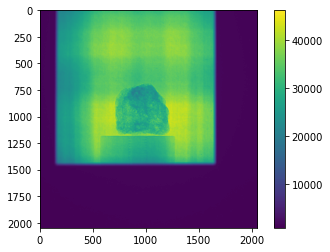

In [5]:
###################### need to change start
ct_scan_dir = os.path.join(ct_scan_loc, "Aug24_2020")
###################### need to change end
# os.listdir(ct_scan_dir)
ct_name, ang_deg, theta, ind_list = get_ind_list(os.listdir(ct_scan_dir))
proj180_ind = find_proj180_ind(ang_deg)[0]
print('Found index of 180 degree projections: ', proj180_ind)
print('Loading CT projections...')
proj = read_tiff_stack(fdir=ct_scan_dir, fname=ct_name)
print(proj.shape)
plt.imshow(proj[0])
plt.colorbar()
plt.show()

# Open Beam (OB)

In [6]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2021_08_19_shale',
 'Nov15_2019',
 'Dec19_2019',
 '2021_08_17_HEA',
 'Dec18_2019',
 'Aug20_2020',
 '2021_04_22',
 'Nov14_2019',
 '2021_03_25',
 'Oct30_2019',
 'Oct29_2019',
 'Nov17_2019',
 'Aug24_2020',
 'December26_2019',
 'June29_2020',
 '2021_09_02_coin_cell_Maha',
 '2021_08_14_zyla_1x_OB_11mm',
 '2021_08_14_zyla_1x_OB_16mm',
 'Aug19_2020',
 'July01_2020',
 '2021_09_03_gold_ore_wim',
 '2021_08_11_plastic',
 'June27_2020',
 '2021_03_25_plastic',
 'Feb10_2020']

Loading Open Beam (OB)...
(10, 2048, 2048)


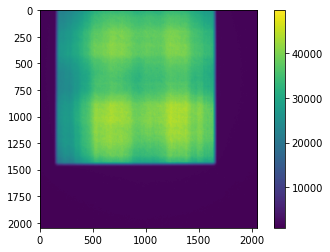

In [7]:
###################### need to change start
ob_dir = os.path.join(ob_loc, "Aug24_2020")
###################### need to change end
# os.listdir(ob_dir)
ob_name, ob_ind_list = get_list(os.listdir(ob_dir))
print("Loading Open Beam (OB)...")
ob = read_tiff_stack(fdir=ob_dir, fname=ob_name)
print(ob.shape)
plt.imshow(ob[0])
plt.colorbar()
plt.show()

# Dark Current (DC)

In [8]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
os.listdir(dc_loc)

['2021_08_19_shale',
 'Aug21_2020',
 'Dec19_2019',
 '2021_05_10_shutter_open',
 'Feb06_2020',
 'Oct29_2019',
 '2021_08_16_DF_high_res',
 '2021_08_19_zyla',
 'Aug24_2020',
 'December26_2019',
 'June29_2020',
 '2021_09_05',
 'Aug25_2020',
 '2021_08_27_DF_30s',
 'Nov12_2019',
 'July01_2020',
 'June27_2020',
 'July02_2020',
 'Feb11_2020',
 'Nov18_2019']

Loading Dark Current (DC)...
(10, 2048, 2048)


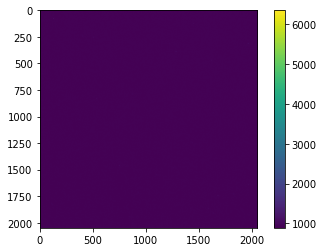

In [9]:
###################### need to change start
dc_dir = os.path.join(dc_loc, "Aug24_2020")
###################### need to change end
# os.listdir(dc_dir)
dc_name, dc_ind_list = get_list(os.listdir(dc_dir))
print("Loading Dark Current (DC)...")
dc = read_tiff_stack(fdir=dc_dir, fname=dc_name)
print(dc.shape)
plt.imshow(dc[0])
plt.colorbar()
plt.show()

# Detect and crop the slits

Slit corners:  [[ 136    0]
 [ 136 1466]
 [1658 1466]
 [1658    0]]
Projection at 0 degree:


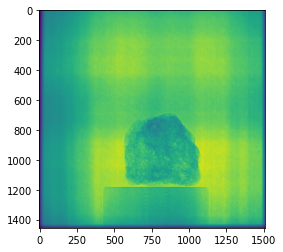

Projection at 180 degree:


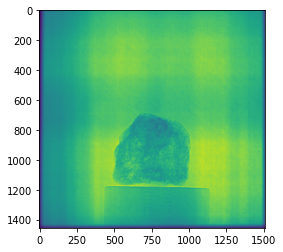

In [10]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob[0], method='simple')
print("Slit corners: ", slit_box_corners)
proj = tomopy.prep.alignment.remove_slits_aps_1id(proj, slit_box_corners)
ob = tomopy.prep.alignment.remove_slits_aps_1id(ob, slit_box_corners)
dc = tomopy.prep.alignment.remove_slits_aps_1id(dc, slit_box_corners)
print("Projection at 0 degree:")
plt.imshow(proj[0])
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj[proj180_ind])
plt.show()

# Further Define the ROI

Projection at 0 degree:


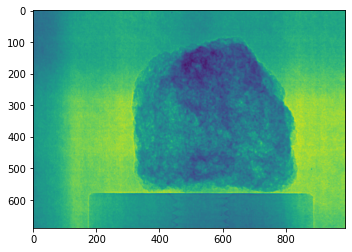

Projection at 180 degree:


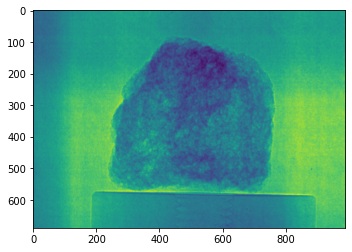

In [11]:
roi_corners = set_roi(corners=slit_box_corners, xmin=250, ymin=600, xmax=1250, ymax=1300)
proj_crop = tomopy.prep.alignment.remove_slits_aps_1id(proj, roi_corners)
ob_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob, roi_corners)
dc_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc, roi_corners)
print("Projection at 0 degree:")
plt.imshow(proj_crop[0])
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_crop[proj180_ind])
plt.show()

# Remove Outliers

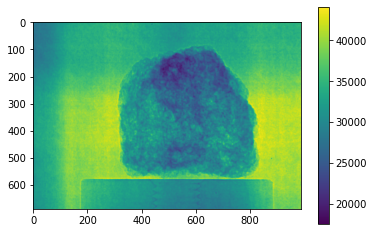

In [13]:
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, 50)
plt.imshow(proj_crop[0])
plt.colorbar()
plt.show()

# Normalization

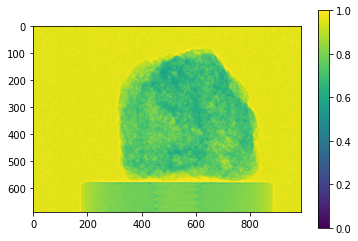

In [14]:
proj_norm = tomopy.normalize(proj_crop, ob_crop, dc_crop)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Beam fluctuation correction

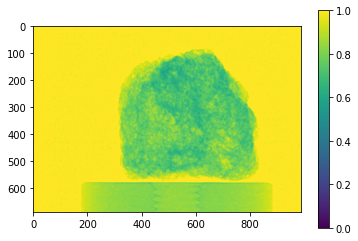

In [15]:
proj_norm = tomopy.prep.normalize.normalize_bg(proj_norm, air=50)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Minus log conversion

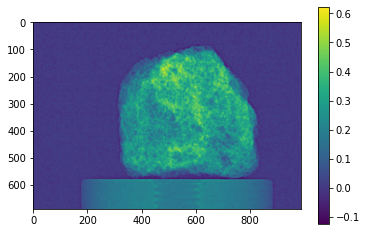

In [16]:
proj_mlog = tomopy.minus_log(proj_norm)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Ring Artifact Removal

Before ring removal:


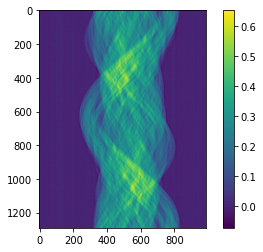

After ring removal:


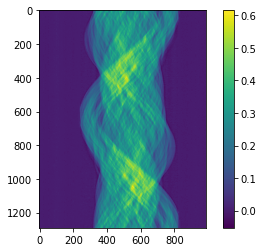

In [17]:
proj_rmv = tomopy.prep.stripe.remove_all_stripe(proj_mlog)
print("Before ring removal:")
plt.imshow(proj_mlog[:, 500, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, 500, :])
plt.colorbar()
plt.show()

In [18]:
# # bm3d, better, but slow
# proj_bm3d_norm = bm3d_rmv.extreme_streak_attenuation(proj_mlog)
# proj_bm3d = bm3d_rmv.multiscale_streak_removal(proj_bm3d_norm)

# Find and correct tilt

Finding the tilt angle...
Found the tilt angle:  -0.592039768397757


/SNS/users/y9z/.conda/envs/tomopy/lib/python3.9/site-packages/imars3d-0.1.3-py3.9.egg/imars3dv2/filters/tilt.py:115: TqdmWarning: Iterable length 1290 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  rst = process_map(
Applying tilt corr: 100%|██████████████████| 1290/1290 [00:07<00:00, 162.54it/s]


Projection at 0 degree:


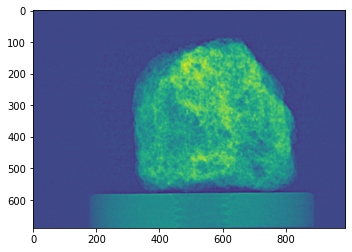

Projection at 180 degree:


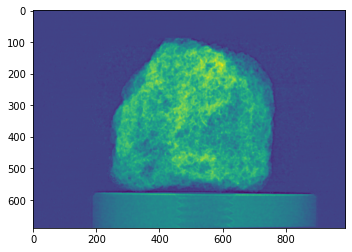

In [19]:
print("Finding the tilt angle...")
tilt_ang = tilt.calculate_tilt(image0=proj_rmv[0], image180=proj_rmv[proj180_ind])
print("Found the tilt angle: ", tilt_ang.x)
proj_tilt = tilt.apply_tilt_correction(proj_rmv, tilt_ang.x)
print("Projection at 0 degree:")
plt.imshow(proj_tilt[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_tilt[proj180_ind])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [20]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_tilt[0,:,:]), np.squeeze(proj_tilt[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation', rot_center)

Estimated center of rotation 537.75


# Reconstruction

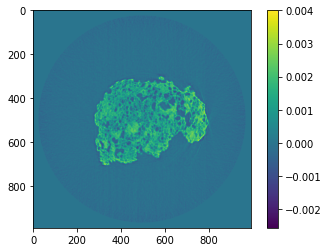

In [21]:
recon = tomopy.recon(proj_tilt, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)
plt.imshow(recon[500, :, :])
plt.colorbar()
plt.show()

# Export recon files

In [22]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit_lava"
fname = save_to + "/recon" 
dxchange.write_tiff_stack(recon, fname=fname, overwrite=True)